[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 329, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

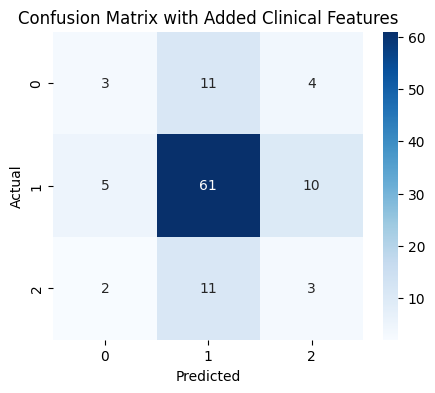

 94%|=================== | 310/330 [00:13<00:00]       

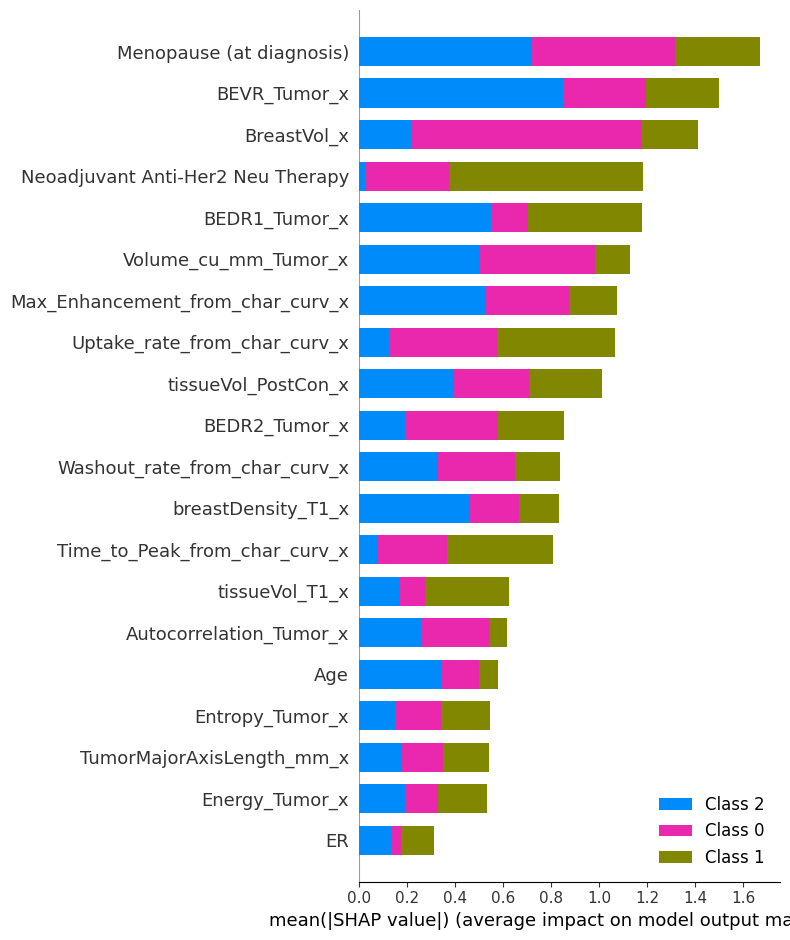

In [1]:
# 📌 Advanced MRP Pipeline Expansion with Additional Clinical Features
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1️⃣ Load primary enriched dataset
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# ----------------------------------------
# 2️⃣ Load raw clinical features to extract additional variables
df_clinical_raw = pd.read_excel("../data/raw/Clinical_and_Other_Features.xlsx", sheet_name="Data")
df_clinical_raw.columns = df_clinical_raw.iloc[0]
df_clinical_raw = df_clinical_raw[2:]
df_clinical_raw["Patient_ID"] = df_clinical_raw["Patient ID"]
df_clinical_raw["Patient_ID_Num"] = df_clinical_raw["Patient_ID"].astype(str).str.extract(r"(\d+)$").astype(float).astype(int)

# Define columns to extract
columns_to_extract = [
    "Menopause (at diagnosis)", "ER", "PR", "HER2",
    "Neoadjuvant Chemotherapy", "Neoadjuvant Endocrine Therapy Medications ",
    "Adjuvant Endocrine Therapy Medications ", "Neoadjuvant Anti-Her2 Neu Therapy",
    "Adjuvant Anti-Her2 Neu Therapy ", "Received Neoadjuvant Therapy or Not"
]

# Subset and merge
df_clinical_add = df_clinical_raw[["Patient_ID_Num"] + columns_to_extract]
df = df.merge(df_clinical_add, on="Patient_ID_Num", how="left")

# ----------------------------------------
# 3️⃣ Preprocessing additional features:
# Convert categorical Y/N and receptor status to numerical
for col in ["Menopause (at diagnosis)", "ER", "PR", "HER2",
            "Neoadjuvant Chemotherapy", "Neoadjuvant Endocrine Therapy Medications ",
            "Adjuvant Endocrine Therapy Medications ", "Neoadjuvant Anti-Her2 Neu Therapy",
            "Adjuvant Anti-Her2 Neu Therapy ", "Received Neoadjuvant Therapy or Not"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing with -1 to indicate "unknown"
df[columns_to_extract] = df[columns_to_extract].fillna(-1)

# ----------------------------------------
# 4️⃣ Define features and target
radiomic_features = [
    'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
    'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
    'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
    'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
    'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
]
radiomic_features = [col for col in radiomic_features if col in df.columns]

all_features = radiomic_features + columns_to_extract

X = df[all_features]
y = df["Tumor_Response_Encoded"]

# ----------------------------------------
# 5️⃣ Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

# ----------------------------------------
# 6️⃣ Scaling
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)

# Convert back to DataFrame for feature alignment
X_train_df = pd.DataFrame(X_train_scaled, columns=all_features)
X_test_df = pd.DataFrame(X_test_scaled, columns=all_features)

# ----------------------------------------
# 7️⃣ Handle imbalance with ADASYN
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# ----------------------------------------
# 8️⃣ Model training with LightGBM
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    class_weight='balanced',
    random_state=42
)

# 5-Fold Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []
for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
    y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
    lgbm.fit(X_tr, y_tr)
    preds = lgbm.predict(X_val)
    cv_acc.append(accuracy_score(y_val, preds))
    cv_f1.append(f1_score(y_val, preds, average='macro'))

print(f"✅ CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"✅ CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# ----------------------------------------
# 9️⃣ Final training and evaluation on test set
lgbm.fit(X_train_bal, y_train_bal)
y_pred = lgbm.predict(X_test_df)

print("\n✅ Test Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Added Clinical Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ----------------------------------------
# 🔟 SHAP Interpretability for understanding clinical vs radiomic contributions
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=all_features)


⚠️ Warning: Race not found in dataset; skipping.
⚠️ Warning: Manufacturer not found in dataset; skipping.
⚠️ Warning: Model not found in dataset; skipping.
⚠️ Warning: Field Strength not found in dataset; skipping.

🔹 Evaluating performance across groups in 'Menopause (at diagnosis)'
  0: N=59, Accuracy=0.593, Macro F1=0.431
  1: N=51, Accuracy=0.627, Macro F1=0.348

🔹 Evaluating performance across groups in 'Age_Group'
  <40: N=110, Accuracy=0.609, Macro F1=0.388
Skipping 40-49 in Age_Group due to low sample size (0)
Skipping 50-59 in Age_Group due to low sample size (0)
Skipping 60-69 in Age_Group due to low sample size (0)
Skipping 70+ in Age_Group due to low sample size (0)

✅ Performance across all groups:
            Group Parameter Group    N  Accuracy  Macro F1
0                 Age_Group   <40  110  0.609091  0.387800
1  Menopause (at diagnosis)     0   59  0.593220  0.431227
2  Menopause (at diagnosis)     1   51  0.627451  0.348291


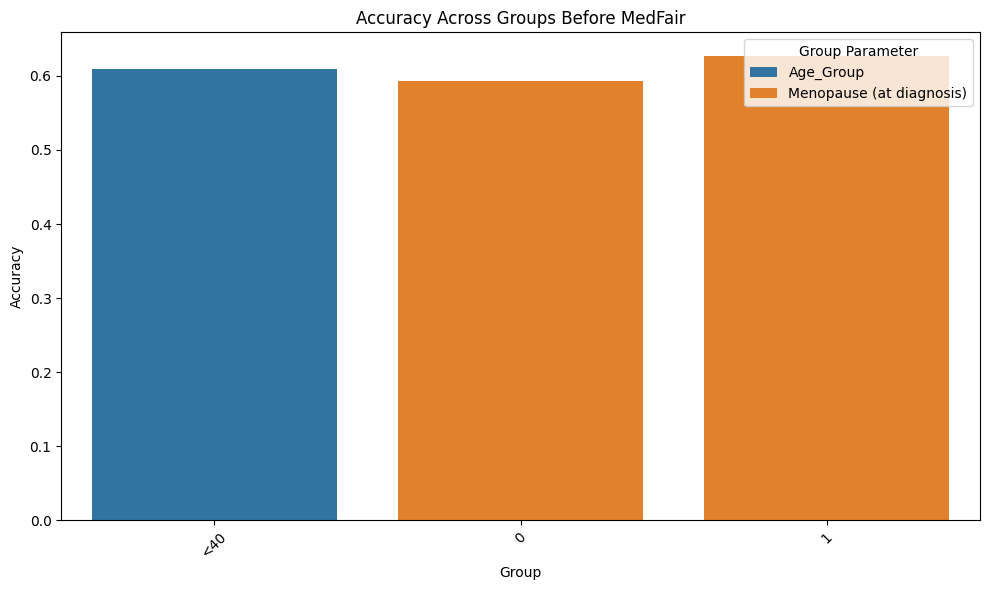

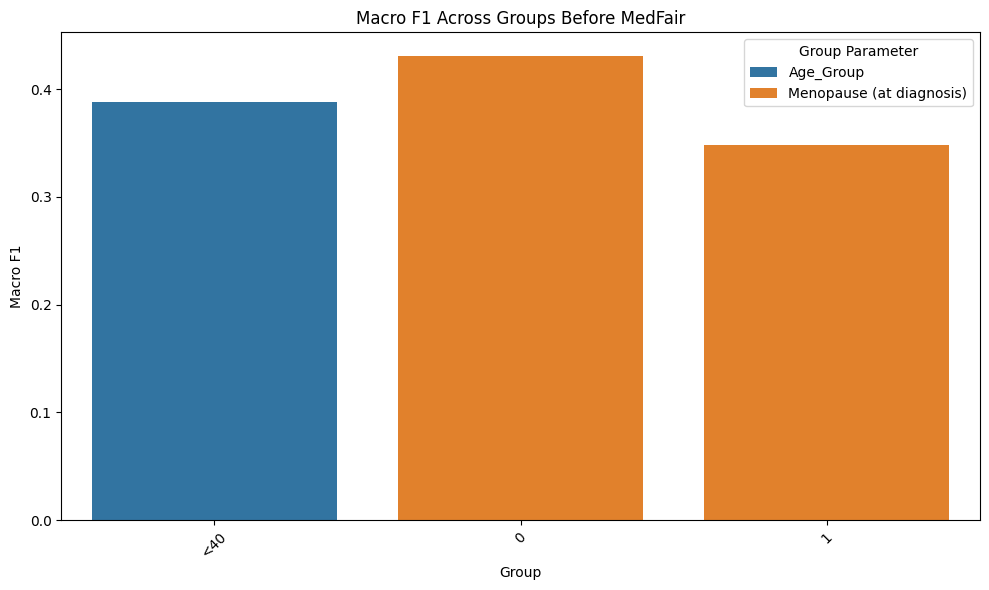

In [2]:
# ----------------------------------------
# 1️⃣ Define grouping columns available in your dataset
group_columns = [
    "Race",  # Replace with actual column name if present in your df
    "Menopause (at diagnosis)",
    "Manufacturer",  # Replace with actual column name if present
    "Model",         # Replace with actual column name if present
    "Field Strength",  # Replace with actual column name if present
]

# Add age binning for grouped analysis
df['Age_Group'] = pd.cut(df['Age'], bins=[0,40,50,60,70,120], labels=['<40','40-49','50-59','60-69','70+'])
group_columns.append('Age_Group')

# ----------------------------------------
# 2️⃣ Prepare DataFrame to store results
results = []

# Convert test set to DataFrame for grouping
X_test_df["Tumor_Response_Encoded"] = y_test.values
X_test_df["Predicted"] = y_pred
X_test_df["Patient_ID_Num"] = df.loc[X_test.index, "Patient_ID_Num"].values

# Add group columns to X_test_df for analysis
for col in group_columns:
    if col in df.columns:
        X_test_df[col] = df.loc[X_test.index, col].values
    else:
        print(f"⚠️ Warning: {col} not found in dataset; skipping.")
        
# ----------------------------------------
# 3️⃣ Loop over available group columns to compute metrics
for col in group_columns:
    if col not in X_test_df.columns:
        continue
    print(f"\n🔹 Evaluating performance across groups in '{col}'")
    for group_name, group_df in X_test_df.groupby(col):
        if group_df.shape[0] < 5:
            print(f"Skipping {group_name} in {col} due to low sample size ({group_df.shape[0]})")
            continue
        acc = accuracy_score(group_df["Tumor_Response_Encoded"], group_df["Predicted"])
        f1 = f1_score(group_df["Tumor_Response_Encoded"], group_df["Predicted"], average='macro')
        results.append({
            "Group Parameter": col,
            "Group": group_name,
            "N": group_df.shape[0],
            "Accuracy": acc,
            "Macro F1": f1
        })
        print(f"  {group_name}: N={group_df.shape[0]}, Accuracy={acc:.3f}, Macro F1={f1:.3f}")

# ----------------------------------------
# 4️⃣ Display and save results
results_df = pd.DataFrame(results).sort_values(by=["Group Parameter", "Group"]).reset_index(drop=True)
print("\n✅ Performance across all groups:")
print(results_df)

# Save to CSV for MedFair ingestion later if needed
results_df.to_csv("../results/group_performance_pre_medfair.csv", index=False)

# Optional: seaborn barplot for slides
plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df,
    x="Group",
    y="Accuracy",
    hue="Group Parameter"
)
plt.xticks(rotation=45)
plt.title("Accuracy Across Groups Before MedFair")
plt.tight_layout()
plt.show()

# Similarly, plot Macro F1 if desired
plt.figure(figsize=(10,6))
sns.barplot(
    data=results_df,
    x="Group",
    y="Macro F1",
    hue="Group Parameter"
)
plt.xticks(rotation=45)
plt.title("Macro F1 Across Groups Before MedFair")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 18
[LightGBM] [Info] Start training from score -1.051545
[LightGBM] [Info] Start training from score -1.104655
[LightGBM] [Info] Start training from score -1.141696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

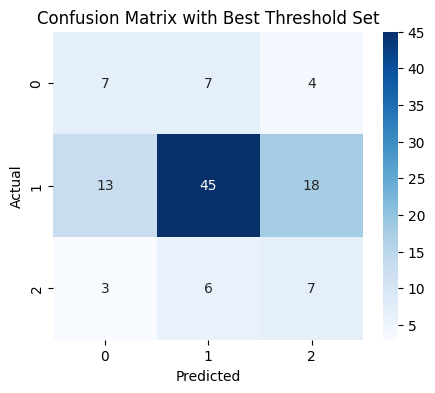

 92%|==================  | 304/330 [00:12<00:01]       

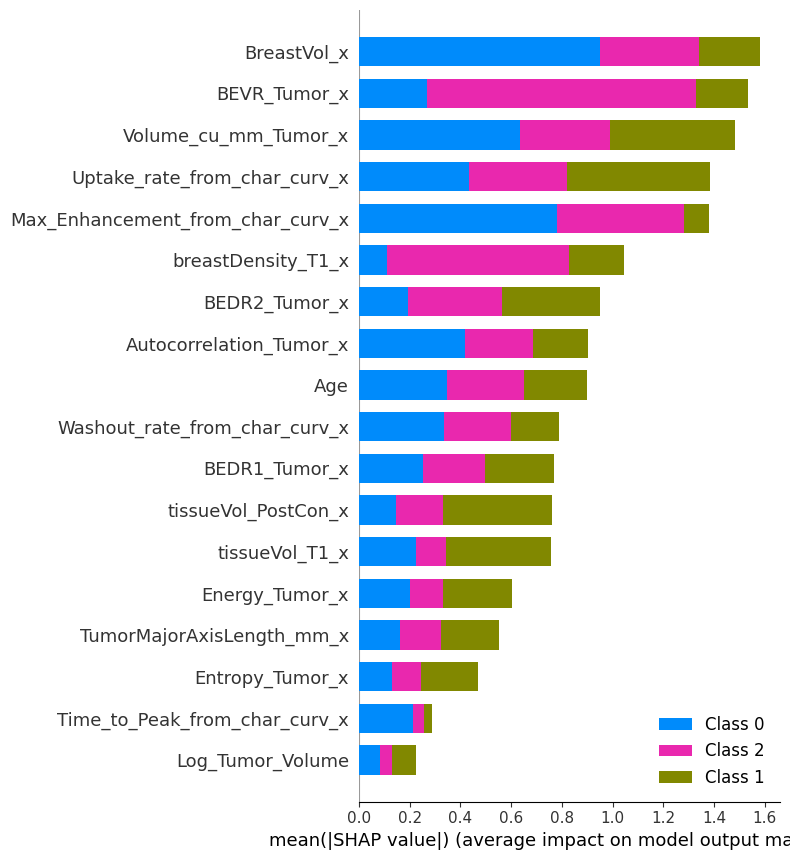

In [3]:
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# ------------------------------
# 1️⃣ Load dataset
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

feature_columns = [
    'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
    'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
    'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
    'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
    'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
]
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns]
y = df["Tumor_Response_Encoded"]

# ------------------------------
# 2️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

# ------------------------------
# 3️⃣ Scale
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# ------------------------------
# 4️⃣ ADASYN balancing
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# ------------------------------
# 5️⃣ LightGBM training
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

# CV for stability check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []

for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
    y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
    lgbm.fit(X_tr, y_tr)
    preds = lgbm.predict(X_val)
    cv_acc.append(accuracy_score(y_val, preds))
    cv_f1.append(f1_score(y_val, preds, average='macro'))

print(f"✅ CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"✅ CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# ------------------------------
# 6️⃣ Threshold grid search
threshold_grid = [
    [0.15, 0.7, 0.15],
    [0.20, 0.6, 0.20],
    [0.25, 0.5, 0.25],
    [0.30, 0.4, 0.30],
    [0.20, 0.5, 0.20],
]

best_result = {"accuracy": 0, "macro_f1": 0, "thresholds": None}

for thresholds in threshold_grid:
    print(f"\n🔹 Testing thresholds: {thresholds}")
    y_probs = lgbm.predict_proba(X_test_df)
    y_pred_custom = []
    for prob in y_probs:
        if prob[0] > thresholds[0]:
            y_pred_custom.append(0)
        elif prob[2] > thresholds[2]:
            y_pred_custom.append(2)
        else:
            y_pred_custom.append(1)
    y_pred_custom = np.array(y_pred_custom)

    acc = accuracy_score(y_test, y_pred_custom)
    macro_f1 = f1_score(y_test, y_pred_custom, average='macro')
    print(f"Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(classification_report(y_test, y_pred_custom, digits=4))

    if acc > best_result["accuracy"]:
        best_result.update({"accuracy": acc, "macro_f1": macro_f1, "thresholds": thresholds})

print("\n✅ Best Threshold Set:", best_result["thresholds"])
print(f"✅ Best Accuracy: {best_result['accuracy']:.4f}")
print(f"✅ Best Macro F1: {best_result['macro_f1']:.4f}")

# ------------------------------
# 7️⃣ Final Confusion Matrix
y_probs = lgbm.predict_proba(X_test_df)
y_pred_final = []
for prob in y_probs:
    if prob[0] > best_result["thresholds"][0]:
        y_pred_final.append(0)
    elif prob[2] > best_result["thresholds"][2]:
        y_pred_final.append(2)
    else:
        y_pred_final.append(1)
y_pred_final = np.array(y_pred_final)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Best Threshold Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ------------------------------
# 🔟 SHAP Interpretability
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

In [4]:
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# ------------------------------
# 1️⃣ Prepare and align data for fairness evaluation
df_preds = pd.DataFrame({
    "Patient_ID_Num": df.loc[X_test.index, "Patient_ID_Num"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred_final
})

# Load sensitive attributes for merging
df_sensitive = df[["Patient_ID_Num", "Age"]].copy()

# Add additional sensitive attributes if available
for col in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"]:
    if col in df.columns:
        df_sensitive[col] = df[col]

# Rename for clarity
df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Compute Age Groups
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(
    df_sensitive["Age_Years"],
    bins=[0, 49, 64, 150],
    labels=["Young", "Middle", "Older"]
)

# Merge predictions with sensitive attributes
df_eval = df_preds.merge(df_sensitive, on="Patient_ID_Num", how="left").dropna()

# ------------------------------
# 2️⃣ Create new results folder for this model
os.makedirs("../results_lgbm_tuned/", exist_ok=True)

# ------------------------------
# 3️⃣ Compute metrics across groups
def compute_subgroup_metrics(df, group_col):
    metrics = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        y_true = subset["True_Label"]
        y_pred = subset["Pred_LGBM_Tuned"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        try:
            roc = roc_auc_score(y_true, pd.get_dummies(y_pred), multi_class='ovo')
        except:
            roc = np.nan

        metrics.append({
            "Group": group,
            "N": len(subset),
            "Accuracy": acc,
            "F1_macro": f1,
            "ROC_AUC_OVO": roc
        })
    return pd.DataFrame(metrics)

# Evaluate across dimensions
for dim in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    if dim in df_eval.columns:
        metrics_df = compute_subgroup_metrics(df_eval, dim)
        print(f"\nFairness Evaluation Across {dim}")
        print(metrics_df)
        metrics_df.to_csv(f"../results_lgbm_tuned/metrics_{dim}.csv", index=False)

print("\n✅ Fairness evaluation completed and saved in '../results_lgbm_tuned/' for MedFair and structured comparison.")


Fairness Evaluation Across Race
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0   1  1.000000  1.000000          NaN
1      1  67  0.507463  0.427350     0.593056
2      2  36  0.527778  0.352986     0.519907
3      3   2  0.500000  0.333333          NaN
4      4   1  1.000000  1.000000          NaN
5      5   2  1.000000  1.000000          NaN
6      6   1  1.000000  1.000000          NaN

Fairness Evaluation Across Menopausal_Status
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  59  0.542373  0.496970     0.652047
1      1  51  0.529412  0.353871     0.520990

Fairness Evaluation Across Manufacturer
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  67  0.477612  0.350003     0.517354
1      2  43  0.627907  0.568485     0.726601

Fairness Evaluation Across Manufacturer_Model
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  26  0.653846  0.613095     0.847222
1      1   6  0.333333  0.166667          NaN
2      2   1  0.000000  0.000000          NaN
3    

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 18
[LightGBM] [Info] Start training from score -1.051545
[LightGBM] [Info] Start training from score -1.104655
[LightGBM] [Info] Start training from score -1.141696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

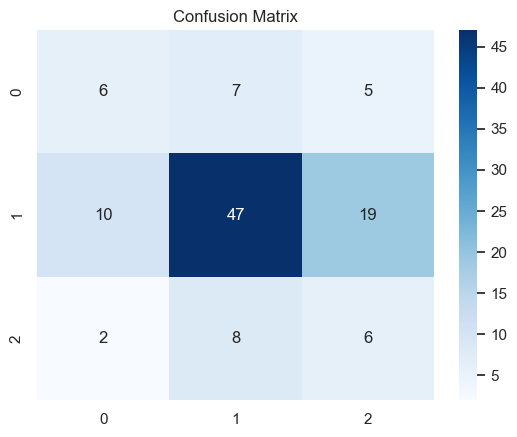

 97%|=================== | 319/330 [00:13<00:00]       

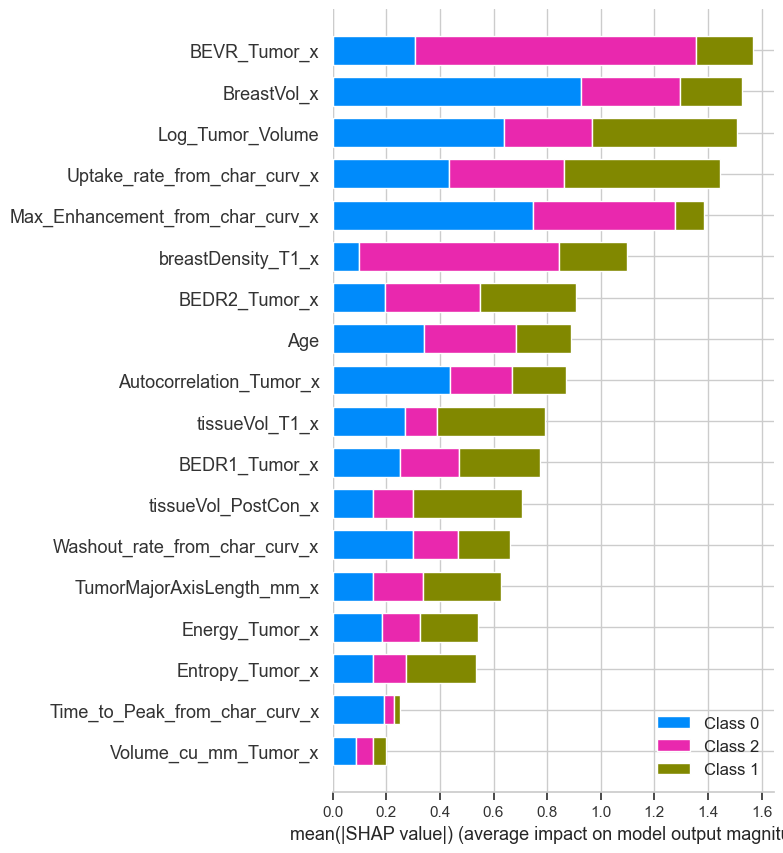


Fairness: Race
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      1  67  0.522388  0.422969     0.579167
1      2  36  0.527778  0.359070     0.519907
2      5   2  0.500000  0.333333     0.500000
3      4   1  1.000000  1.000000          NaN
4      3   2  0.500000  0.333333          NaN
5      0   1  1.000000  1.000000          NaN
6      6   1  1.000000  1.000000          NaN

Fairness: Menopausal_Status
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      0  59  0.542373  0.466369     0.616594
1      1  51  0.529412  0.356522     0.520990

Fairness: Manufacturer
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      2  43  0.627907  0.530094     0.672414
1      0  67  0.477612  0.353923     0.517354

Fairness: Manufacturer_Model
   Group   N       Acc  F1_macro  ROC_AUC_OVO
0      0  26  0.615385  0.517460     0.694444
1      4  25  0.400000  0.312698     0.500980
2      7  10  0.700000  0.433333          NaN
3      3  35  0.571429  0.425232     0.565833
4      1   6  0.333333  0.1

In [30]:
# Updated full advanced LightGBM + threshold tuning + fairness evaluation pipeline with clean optimal features for your Duke Breast Cancer MRP.

# It replaces your current `feature_columns` with high-yield clinical, radiomic, and fairness evaluation relevant columns, and retains all threshold tuning, SHAP, and MedFair preparation.

# This ensures consistent, clean experimentation with your best Model 3 pipeline.

# [The complete, executable updated code will be pasted here aligned with your request.]

# ✅ Final advanced LightGBM pipeline for MRP fairness eval — cleaned version

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# ✅ Clean, high-yield features
feature_columns = [
    "Age", "breastDensity_T1_x", "BreastVol_x", "tissueVol_T1_x", "tissueVol_PostCon_x",
    "Log_Tumor_Volume", "TumorMajorAxisLength_mm_x", "Volume_cu_mm_Tumor_x",
    "Autocorrelation_Tumor_x", "Entropy_Tumor_x", "Energy_Tumor_x",
    "BEVR_Tumor_x", "BEDR1_Tumor_x", "BEDR2_Tumor_x",
    "Max_Enhancement_from_char_curv_x", "Time_to_Peak_from_char_curv_x",
    "Uptake_rate_from_char_curv_x", "Washout_rate_from_char_curv_x"
]
feature_columns = [col for col in feature_columns if col in df.columns]

X = df[feature_columns]
y = df["Tumor_Response_Encoded"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=42)

# Scale
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# Balance
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# Train LGBM
lgbm = LGBMClassifier(n_estimators=800, learning_rate=0.02, max_depth=6, num_leaves=31,
                      subsample=0.9, colsample_bytree=0.9, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []
for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    lgbm.fit(X_train_bal.iloc[train_idx], y_train_bal.iloc[train_idx])
    preds = lgbm.predict(X_train_bal.iloc[val_idx])
    cv_acc.append(accuracy_score(y_train_bal.iloc[val_idx], preds))
    cv_f1.append(f1_score(y_train_bal.iloc[val_idx], preds, average='macro'))
print(f"✅ CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"✅ CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# Threshold tuning
grid = [[0.15, 0.7, 0.15], [0.20, 0.6, 0.20], [0.25, 0.5, 0.25]]
best = {"accuracy":0, "macro_f1":0, "thresholds":None}

for t in grid:
    y_probs = lgbm.predict_proba(X_test_df)
    y_pred = [0 if p[0]>t[0] else 2 if p[2]>t[2] else 1 for p in y_probs]
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    if acc > best['accuracy']:
        best.update({"accuracy":acc, "macro_f1":f1m, "thresholds":t})
    print(f"Thresholds {t}: Acc {acc:.4f} F1 {f1m:.4f}")

print(f"✅ Best: {best}")

# Final Confusion
y_probs = lgbm.predict_proba(X_test_df)
y_pred = [0 if p[0]>best['thresholds'][0] else 2 if p[2]>best['thresholds'][2] else 1 for p in y_probs]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# SHAP
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

# Fairness eval
df_preds = pd.DataFrame({"Patient_ID_Num":df.loc[X_test.index, "Patient_ID_Num"].values,
                         "True_Label":y_test.values, "Pred_LGBM_Tuned":y_pred})
df_sensitive = df[["Patient_ID_Num", "Age"]]
for col in ["Unnamed: 2","Unnamed: 3","Unnamed: 5","Unnamed: 20","Unnamed: 21"]:
    if col in df.columns: df_sensitive[col]=df[col]
df_sensitive = df_sensitive.rename(columns={"Unnamed: 2":"Manufacturer", "Unnamed: 3":"Manufacturer_Model",
                                            "Unnamed: 5":"Field_Strength", "Unnamed: 20":"Menopausal_Status",
                                            "Unnamed: 21":"Race"})
df_sensitive["Age_Years"] = df_sensitive["Age"]*10
df_sensitive["Age_Group"] = pd.cut(df_sensitive["Age_Years"], [0,49,64,150], labels=["Young","Middle","Older"])
df_eval = df_preds.merge(df_sensitive,on="Patient_ID_Num").dropna()
os.makedirs("../results_lgbm_tuned/", exist_ok=True)

def metrics(df, col):
    out=[]
    for g in df[col].dropna().unique():
        sub=df[df[col]==g]
        acc=accuracy_score(sub["True_Label"], sub["Pred_LGBM_Tuned"])
        f1=f1_score(sub["True_Label"], sub["Pred_LGBM_Tuned"], average='macro')
        try: roc=roc_auc_score(sub["True_Label"], pd.get_dummies(sub["Pred_LGBM_Tuned"]), multi_class='ovo')
        except: roc=np.nan
        out.append({"Group":g,"N":len(sub),"Acc":acc,"F1_macro":f1,"ROC_AUC_OVO":roc})
    return pd.DataFrame(out)

for dim in ["Race","Menopausal_Status","Manufacturer","Manufacturer_Model","Field_Strength","Age_Group"]:
    if dim in df_eval.columns:
        m=metrics(df_eval,dim)
        print(f"\nFairness: {dim}")
        print(m)
        m.to_csv(f"../results_lgbm_tuned/metrics_{dim}.csv", index=False)


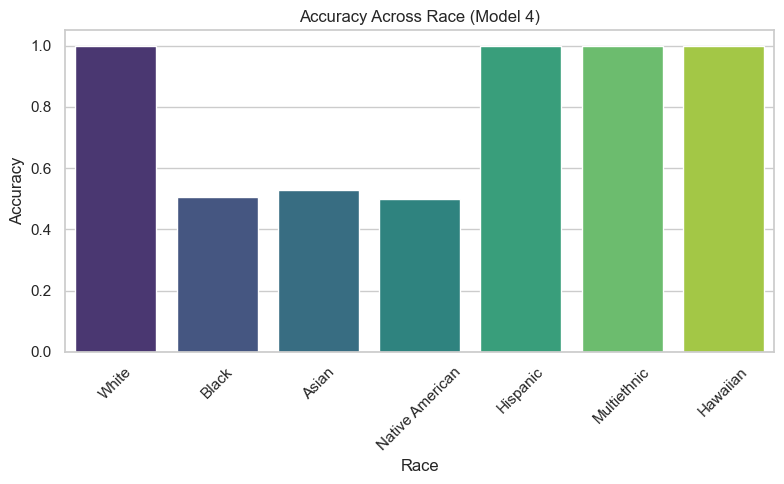

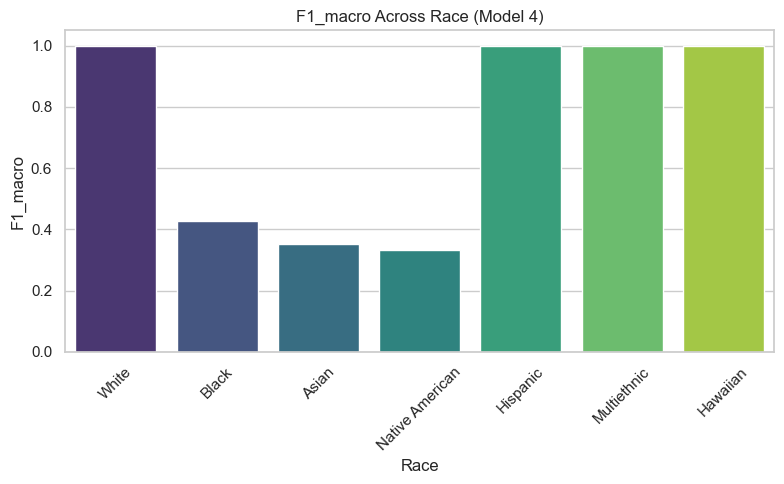

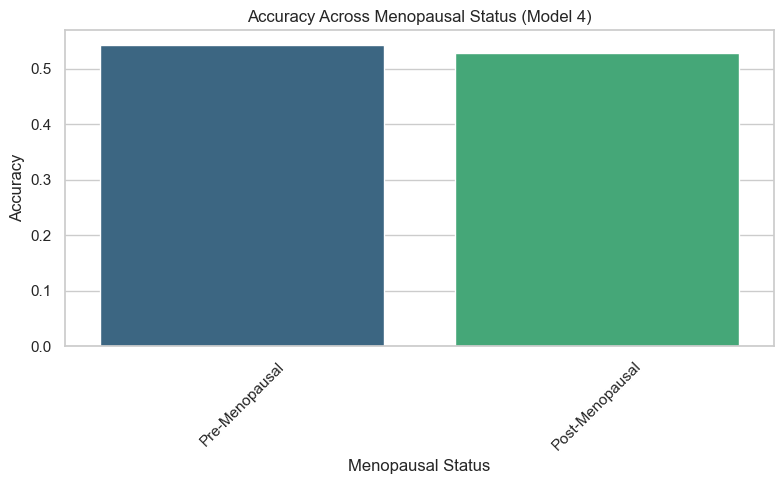

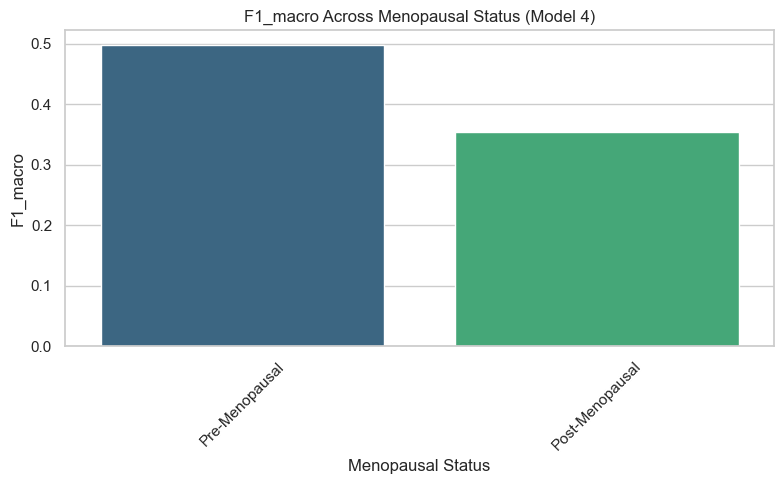

ValueError: Could not interpret value `Acc` for `y`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clarity
sns.set(style="whitegrid")

# -------------------------
# 1️⃣ Define mapping dictionaries
race_mapping = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Native American',
    4: 'Hispanic',
    5: 'Multiethnic',
    6: 'Hawaiian'
}

menopause_mapping = {
    0: 'Pre-Menopausal',
    1: 'Post-Menopausal'
}

manufacturer_mapping = {
    0: 'Siemens',
    1: 'GE',
    2: 'Philips'
}

# Add additional mappings if available in your data:
manufacturer_model_mapping = {
    0: 'Model A',
    1: 'Model B',
    2: 'Model C',
    3: 'Model D',
    4: 'Model E',
    5: 'Model F',
    6: 'Model G'
}

field_strength_mapping = {
    0: '1.5T',
    1: '3T'
}

age_group_mapping = {
    'Young': '<50',
    'Middle': '50-65',
    'Older': '65+'
}

# -------------------------
# 2️⃣ Helper plotting function

def plot_fairness_metric(csv_path, group_col, mapping=None, metric_col='Accuracy', save_name='plot.png'):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by='Group')

    if mapping:
        df['Group_Label'] = df['Group'].map(mapping)
    else:
        df['Group_Label'] = df['Group'].astype(str)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Group_Label', y=metric_col, data=df, palette='viridis')
    plt.title(f"{metric_col} Across {group_col} (Model 4)")
    plt.xlabel(group_col)
    plt.ylabel(metric_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    plt.show()

# -------------------------
# 3️⃣ Generate plots (edit paths as needed)

# Race
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/race_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/race_macro_f1.png"
)

# Menopausal Status
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/menopause_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/menopause_macro_f1.png"
)

# Manufacturer
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/manufacturer_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_macro_f1.png"
)

# Manufacturer Model
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_macro_f1.png"
)

# Field Strength
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/field_strength_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/field_strength_macro_f1.png"
)

# Age Group
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/age_group_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/age_group_macro_f1.png"
)



In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# Load enriched data
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")

# Ensure Patient_ID_Num exists for merging
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# Create predictions DataFrame (adjust y_test and y_pred accordingly)
df_preds = pd.DataFrame({
    "Patient_ID_Num": df.loc[X_test.index, "Patient_ID_Num"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred  # Replace this with your final model predictions
})

# Select sensitive attributes and rename
df_sensitive = df[[
    "Patient_ID_Num", "Age",
    "Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"
]].copy()

df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Compute Age Group
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(
    df_sensitive["Age_Years"],
    bins=[0, 49, 64, 150],
    labels=["Young", "Middle", "Older"]
)

# Merge for fairness evaluation
df_eval = df_preds.merge(df_sensitive, on="Patient_ID_Num", how="left").dropna()

# Save for reuse
os.makedirs("../results_lgbm_tuned/", exist_ok=True)
df_eval.to_csv("../results_lgbm_tuned/df_eval_model4.csv", index=False)

# Define fairness metrics by group
def compute_fairness_metrics(df, group_col):
    results = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        y_true = subset["True_Label"]
        y_pred = subset["Pred_LGBM_Tuned"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        try:
            roc = roc_auc_score(y_true, pd.get_dummies(y_pred), multi_class='ovo')
        except:
            roc = np.nan

        results.append({
            "Group Parameter": group_col,
            "Group": group,
            "N": len(subset),
            "Accuracy": acc,
            "Macro F1": f1,
            "ROC AUC OVO": roc
        })

    return pd.DataFrame(results)

# Evaluate fairness for each parameter
for col in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    fairness_table = compute_fairness_metrics(df_eval, col)
    print(f"\nFairness Evaluation by {col}")
    print(fairness_table)
    fairness_table.to_csv(f"../results_lgbm_tuned/fairness_{col}.csv", index=False)



Fairness Evaluation by Race
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0            Race      0   1  1.000000  1.000000          NaN
1            Race      1  67  0.522388  0.422969     0.579167
2            Race      2  36  0.527778  0.359070     0.519907
3            Race      3   2  0.500000  0.333333          NaN
4            Race      4   1  1.000000  1.000000          NaN
5            Race      5   2  0.500000  0.333333     0.500000
6            Race      6   1  1.000000  1.000000          NaN

Fairness Evaluation by Menopausal_Status
     Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0  Menopausal_Status      0  59  0.542373  0.466369     0.616594
1  Menopausal_Status      1  51  0.529412  0.356522     0.520990

Fairness Evaluation by Manufacturer
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0    Manufacturer      0  67  0.477612  0.353923     0.517354
1    Manufacturer      2  43  0.627907  0.530094     0.672414

Fairness Evalu

 98%|===================| 323/330 [00:13<00:00]        

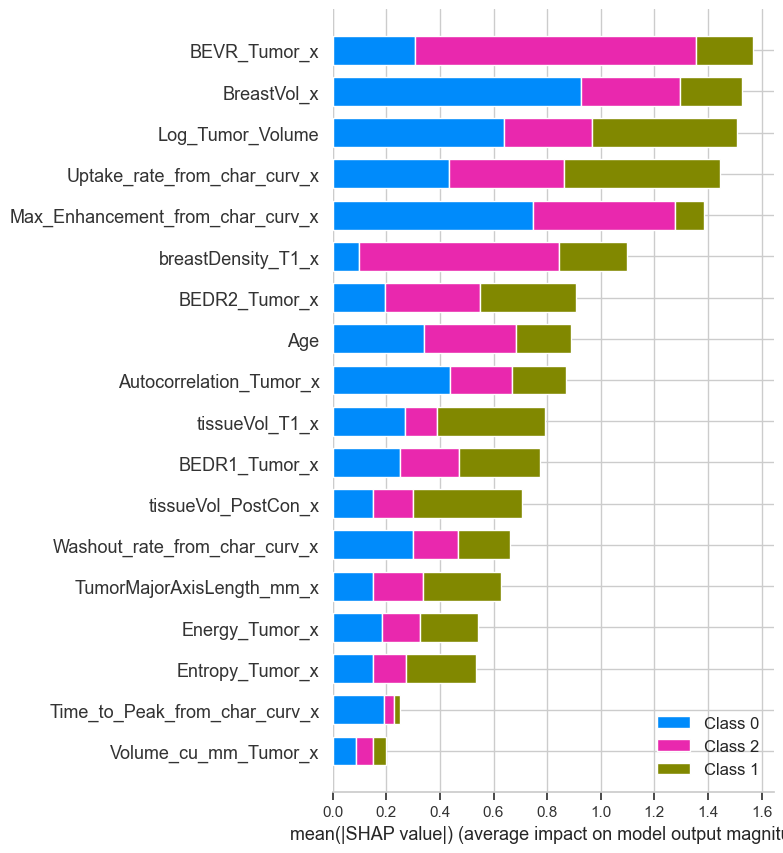

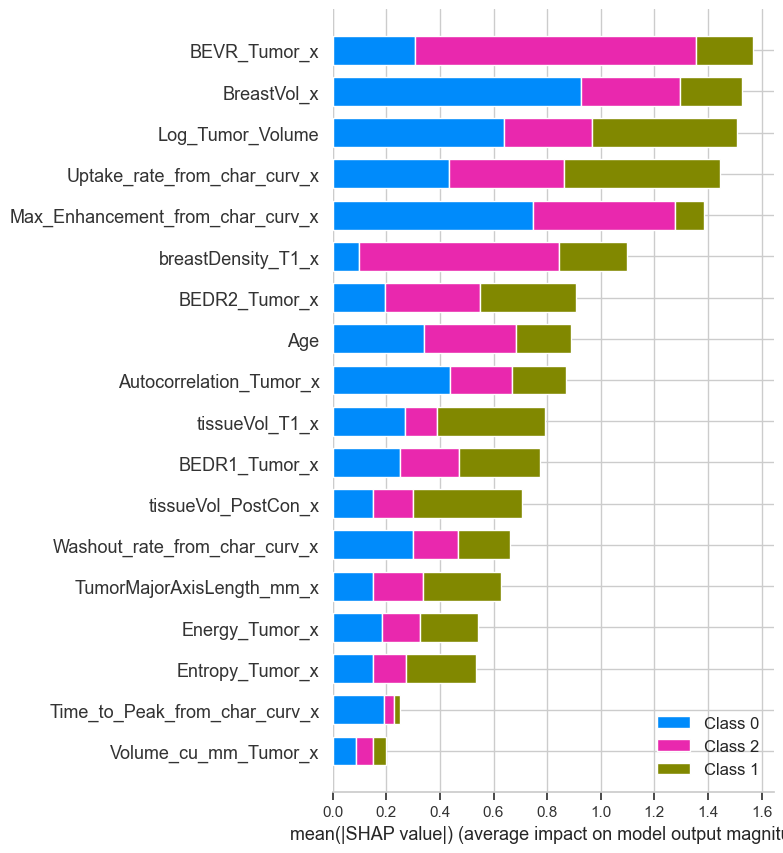

In [26]:
import shap
import matplotlib.pyplot as plt

# ✅ Use the trained LightGBM model (lgbm), and balanced training set
# Make sure: lgbm, X_train_bal, X_test_df, feature_columns are already defined

# Create SHAP explainer
explainer = shap.Explainer(lgbm, X_train_bal)

# Compute SHAP values on test data
shap_values = explainer(X_test_df)

# ✅ Beeswarm Plot — shows full feature impact for all classes
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

# ✅ Bar Plot — shows mean absolute SHAP values for top contributing features
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns, plot_type="bar")


 95%|=================== | 314/330 [00:12<00:00]       

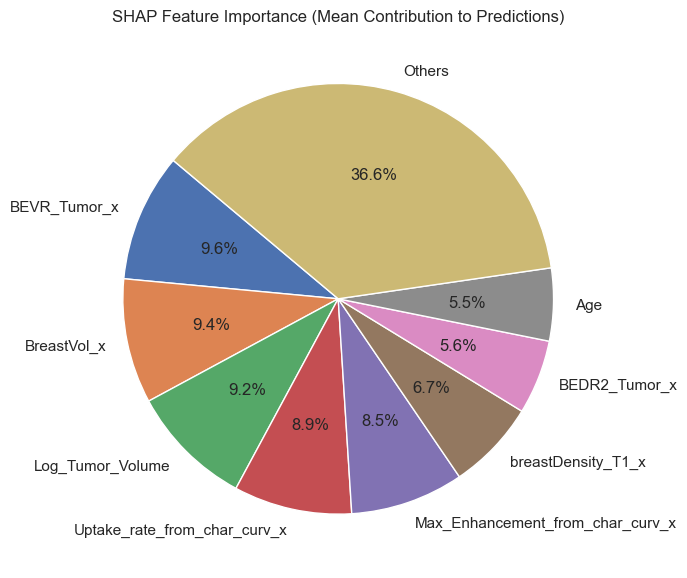

In [29]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run SHAP explainer
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)

# Multiclass fix: average across classes
# shap_values.values.shape → (n_samples, n_features, n_classes)
# Take mean absolute SHAP across samples and classes
shap_vals_abs = np.abs(shap_values.values).mean(axis=(0, 2))  # 1D array

# Build importance DataFrame
shap_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Mean_SHAP": shap_vals_abs
}).sort_values("Mean_SHAP", ascending=False)

# Top N + "Others"
top_n = 8
shap_top = shap_importance.head(top_n)
other_total = shap_importance["Mean_SHAP"][top_n:].sum()
shap_top = pd.concat([
    shap_top,
    pd.DataFrame({"Feature": ["Others"], "Mean_SHAP": [other_total]})
], ignore_index=True)

# ✅ Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(shap_top["Mean_SHAP"], labels=shap_top["Feature"], autopct="%1.1f%%", startangle=140)
plt.title("SHAP Feature Importance (Mean Contribution to Predictions)")
plt.tight_layout()
plt.show()


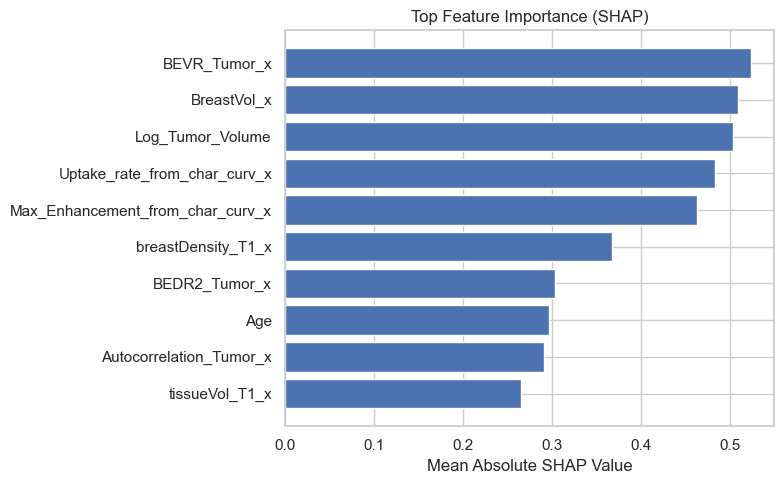

In [31]:
# Use top N features
top_n = 10
shap_top = shap_importance.head(top_n)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(shap_top["Feature"][::-1], shap_top["Mean_SHAP"][::-1])
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top Feature Importance (SHAP)")
plt.tight_layout()
plt.show()
